In [20]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from scipy.signal import convolve
import scipy
from joblib import Parallel, delayed
import time
from scipy import sparse
from tqdm import tqdm, tqdm_notebook

%run ../Scripts/mutation.py
%run ../Scripts/initMethods.py
%run ../Scripts/formulas.py
%run ../Scripts/entropy.py

In [4]:
params = { #parameters relevant for the equations
    "Nh":           10000,
    "N0":          100000,
    "M":                1, #Also L, total number of spacers
    "mu":               1, #mutation rate
    "gamma_shape":     20, 
}
sim_params = { #parameters relevant for the simulation (including Inital Valuess)
    "xdomain":                    100,
    "dx":                           1,
    "dt":                           1,
    "initial_mean_n":           [0,0],
    "initial_var_n":               10,
    "num_threads":                  4,
}

In [5]:
n = init_guassian(params["N0"], sim_params, "n")
n_new = mutation(n, params, sim_params)
xdomain = sim_params["xdomain"]
dx = sim_params["dx"]
xspace = np.arange(-xdomain, xdomain, dx )

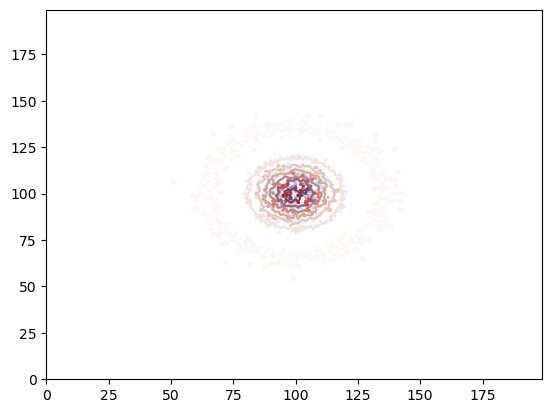

In [6]:
plt.contour(n.todense(), cmap = "Reds")
plt.contour(n_new.todense(), cmap = "Blues", alpha = 0.5)

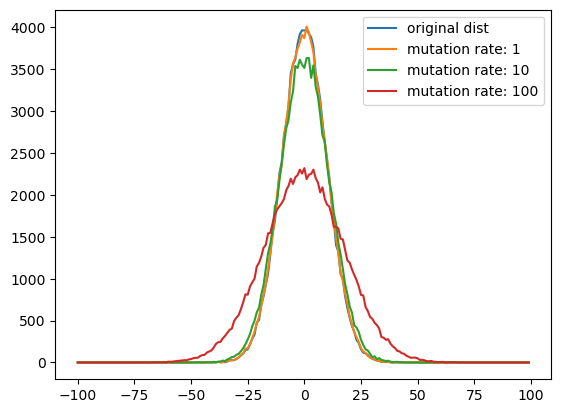

In [7]:
n = init_guassian(params["N0"], sim_params, "n")
flat_n = np.array(np.sum(n.todense(), axis=0)).squeeze()
plt.plot(xspace, flat_n, label = "original dist")
for i in [1, 10, 100]:
    params["mu"] = i
    n_new = mutation(n, params, sim_params)
    flat_n_new = np.array(np.sum(n_new.todense(), axis=0)).squeeze()
    plt.plot(xspace, flat_n_new, label=f"mutation rate: {i}")
plt.legend()

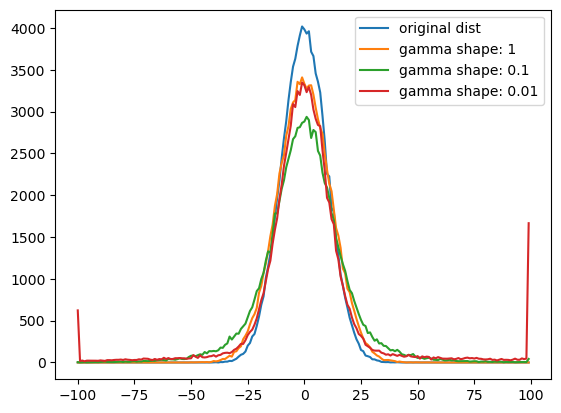

In [8]:
n = init_guassian(params["N0"], sim_params, "n")
params["mu"] = 10

flat_n = np.array(np.sum(n.todense(), axis=0)).squeeze()
plt.plot(xspace, flat_n, label = "original dist")
for i in [1, 1/10, 1/100]:
    params["gamma_shape"] = i
    n_new = mutation(n, params, sim_params)
    flat_n_new = np.array(np.sum(n_new.todense(), axis=0)).squeeze()
    plt.plot(xspace, flat_n_new, label=f"gamma shape: {i}")
plt.legend()

In [95]:
%run ../Scripts/entropy.py

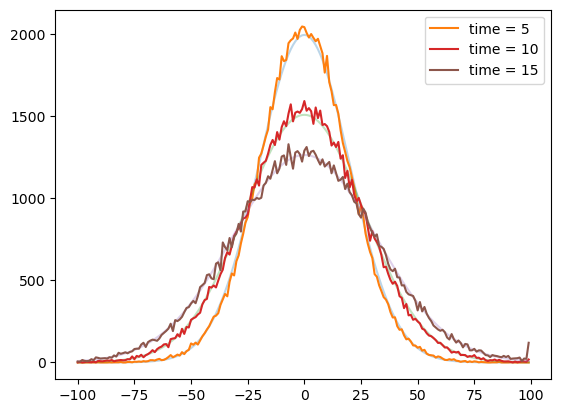

In [99]:
t = 20
n_old = init_guassian(params["N0"], sim_params, "n")
flat_n_old = np.array(np.sum(n_old.todense(), axis=0)).squeeze()
params["mu"] = mu = 10
params["gamma_shape"]= 0.5

n_new = mutation(n_old, params, sim_params)
entropy_change = np.zeros(t)
N = params["N0"]

for i in range(1, t):
    func = params["N0"]*guassian_diffusion(xspace, xspace, i, params, sim_params)
    flat_func = np.sum(func, axis = 0)

    n_new = mutation(n_old, params, sim_params)
    flat_n_new = np.array(np.sum(n_new.todense(), axis=0)).squeeze()

    if i%5 ==0 :
        plt.plot(xspace, flat_func, alpha = 0.3)
        plt.plot(xspace, flat_n_new, label = f"time = {i}")

    entropy_change[i] = compute_entropy_change(n_new, n_old)
    n_old = n_new
plt.legend()
plt.show()

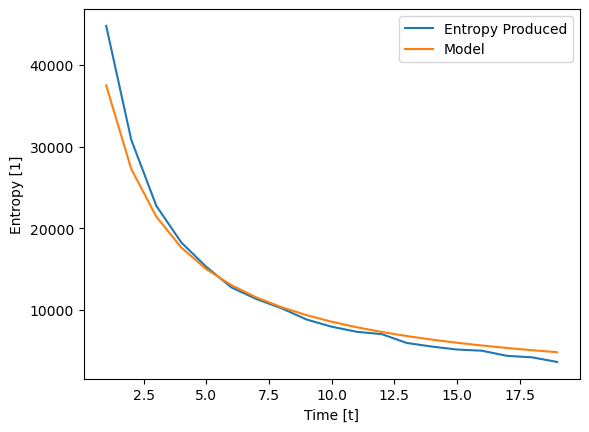

In [98]:
plt.figure()
t_range = np.arange(1, t)
N = params["N0"]

var = sim_params["initial_var_n"]
diff_const = calc_diff_const(params, sim_params)
plt.plot(t_range, entropy_change[1:], label = "Entropy Produced")
plt.plot(t_range, N*entropy_production_mutation(var**2, diff_const,t_range), label = "Model")
plt.ylabel("Entropy [1]")
plt.xlabel("Time [t]")
plt.legend()
plt.show()